### 데이터 살펴보기

메서드 불러오기

In [15]:
import pandas as pd
import numpy as np

# 시각화
import seaborn as sns

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('seaborn : %s'%(sns.__version__))
!python --version

Pandas : 1.2.1
seaborn : 0.11.2
Python 3.8.13


In [16]:
# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

In [17]:
# 데이터 불러오기
user = pd.read_csv('../data/user_spec.csv')
loan = pd.read_csv('../data/loan_result.csv')
log = pd.read_csv('../data/log_data.csv')

### 1. 유저 스펙 테이블

- na값에 대한 확인

In [18]:
user.isna().sum()

application_id                               0
user_id                                      0
birth_year                               12961
gender                                   12961
insert_time                                  0
credit_score                            105115
yearly_income                               90
income_type                                 85
company_enter_month                     171760
employment_type                             85
houseown_type                               85
desired_amount                              85
purpose                                     85
personal_rehabilitation_yn              587461
personal_rehabilitation_complete_yn    1203354
existing_loan_cnt                       198556
existing_loan_amt                       313774
dtype: int64

    - birth_year와 gender 결측값 채워줌

In [19]:
###### birth_year #####
birth_year_mean = user['birth_year'].mean()
user['birth_year'] = user['birth_year'].fillna('없음')

# 전처리할 데이터 재생성
bir = user.groupby('user_id')['birth_year'].apply(set).reset_index()
bir['len'] = bir['birth_year'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove0(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
bir['birth_year'].apply(remove0)
bir['year'] = bir['birth_year'].apply(lambda x:list(x)[0])

# 없음을 평균으로 채워줌
bir['year'] = bir['year'].apply(lambda x:birth_year_mean if x == '없음' else x)

In [20]:
# 딕셔너리로 변환하여 저장
birth_year = {x:y for x,y in zip(bir['user_id'], bir['year'])}

# 적용하여 변환
user['birth_year'] = user['user_id'].apply(lambda x:birth_year[x])

In [21]:
###### gender #####
user['gender'] = user['gender'].fillna('없음')

# 전처리할 데이터 재생성
g = user.groupby('user_id')['gender'].apply(set).reset_index()
g['len'] = g['gender'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove2(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
g['gender'].apply(remove2)
g['g'] = g['gender'].apply(lambda x:list(x)[0])
g['g'] = g['g'].apply(lambda x:1 if x == '없음' else x)

# 딕셔너리로 변환하여 저장
gender = {x:y for x,y in zip(g['user_id'], g['g'])}

# 적용하여 변환
user['gender'] = user['user_id'].apply(lambda x:gender[x])

    - personal_rehabilitation_complete_yn
        -> 문의 필요

In [22]:
# na값을 확인 하였을 때, personal_rehabilitation_complete_yn의 값이 높은데, 이는 개인 회생자가 아닌 사람도 포함 돼있기 때문으로 보임
## na중 personal_rehabilitation_yn의 값이 0인 값은 개인회생자 아님 등으로 채워야할 듯함
user[user['personal_rehabilitation_complete_yn'].isna()]['personal_rehabilitation_yn'].unique()

array([ 0., nan])

In [23]:
user.query('personal_rehabilitation_yn == 0')['personal_rehabilitation_complete_yn'].value_counts()

0.0    178149
1.0         4
Name: personal_rehabilitation_complete_yn, dtype: int64

In [24]:
user.query('personal_rehabilitation_yn == 1')['personal_rehabilitation_complete_yn'].value_counts()

0.0    11361
1.0     1348
Name: personal_rehabilitation_complete_yn, dtype: int64

분포를 확인해보았을 때, personal_rehabilitation_complete_yn에 기록이 있으면 personal_rehabilitation_yn가 1인 것으로 생각하여 채워야될듯함

In [25]:
# 기록이 있으면 개인회생자, 없으면 아닌 사람으로 기록
user['personal_rehabilitation_yn'] = user['personal_rehabilitation_complete_yn'].apply(lambda x:1 if x in [0,1] else 0)
# 나머지 기록이 na인 값은 전부 개인회생자가 아닌 것으로 확인함 -> 2( 개인회생자아님 )로 채워줌
user['personal_rehabilitation_complete_yn'] = user['personal_rehabilitation_complete_yn'].fillna(2)

    - company_enter_month

In [26]:
# company_enter_month에 대한 na값은 입사 년월을 입력하지 못하는 사람들이 대부분임
## 입사년월이 없는 사람 (ex)개인 사업, 소득이 회사가 아닌 경우 등 )
## 다른 옵션으로 채워야할듯함
user[user['company_enter_month'].isna()]['income_type'].value_counts()

OTHERINCOME        171665
EARNEDINCOME            7
PRIVATEBUSINESS         3
Name: income_type, dtype: int64

In [27]:
# OTHERINCOME을 제외하면 na값이 적기 때문에 입사년도 없음으로 채워줌
user['company_enter_month'] = user['company_enter_month'].fillna('입사년도 없음')

    - credit_score

In [28]:
# 68018명의 사람들의 신용정보 확인 불가능
user[['user_id', 'credit_score']].drop_duplicates(subset='user_id').isna().sum()

user_id             0
credit_score    68018
dtype: int64

In [29]:
# 신용 점수가 있는 고객들은 해당 고객이 가진 신용 점수의 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user.groupby('user_id')['credit_score'].transform('mean'))

In [30]:
# 채운 후에도 na값인 경우는 신용 점수를 확인한 적이 한번도 없는 고객임
user[user['credit_score'].isna()].groupby('user_id')['credit_score'].count().unique()

array([0], dtype=int64)

In [31]:
# # 컬럼들과 credit score간의 상관관계를 시각화해 보았으나 의미 X 그냥 평균으로 채움

# sns.clustermap(user.corr(), 
#                annot = True,      # 실제 값 화면에 나타내기
#                cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
#                vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
#               )

In [32]:
# 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user['credit_score'].mean())

    - existing_loan_cnt

In [33]:
# existing_loan_cnt의 값이 0인 행이 없는 것으로 보아 na인 경우는 기대출수가 0이지 않을까 하는 추축
user[user['existing_loan_cnt'] == 0]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt


In [34]:
# existing_loan_cnt가 na인 값의 amt는 모두 na인 모습을 보임
user[user['existing_loan_cnt'].isna()][['existing_loan_cnt','existing_loan_amt']].isna().sum()

existing_loan_cnt    198556
existing_loan_amt    198556
dtype: int64

In [35]:
# existing_loan_cnt와 existing_loan_amt의 수가 na인 값은 0으로 채워줌
user['existing_loan_cnt'] = user['existing_loan_cnt'].fillna(0)
user['existing_loan_amt'] = user['existing_loan_amt'].fillna(0)

    - yearly_income, income_type

In [36]:
# 연소득이 na인 값의 소득 경로를 확인해 본 결과 na인 값이 85개, 다른 수익 4, 프리랜서가 1인 모습을 보임
## -> 즉, na인 것은 연소득이 없다는 뜻임
user[user['yearly_income'].isna()]['income_type'].value_counts()

OTHERINCOME    4
FREELANCER     1
Name: income_type, dtype: int64

In [37]:
# 0으로 채워줌
user['yearly_income'] = user['yearly_income'].fillna(0)
user['income_type'] = user['income_type'].fillna('직장없음')

    - employment_type

In [38]:
# employment_type의 경우 company_enter_month의 값이 입사년도없음임
user[user['employment_type'].isna()]['company_enter_month'].unique()

array(['입사년도 없음'], dtype=object)

In [39]:
# 입사년도가 없다는 것은 기타이기 때문에 기타로 채워줌
user['employment_type'] = user['employment_type'].fillna('기타')

    - houseown_type

In [40]:
# houseown_type이 na인 값은 그냥 귀찮아서 안찍은듯함
user['houseown_type'].unique()

array(['자가', '기타가족소유', '전월세', '배우자', nan], dtype=object)

In [41]:
## -> 정보없음으로 채워줌
user['houseown_type'] = user['houseown_type'].fillna('정보없음')

    - desired_amount

In [42]:
# 이 경우도 선택을 그냥 하지 않은 경우이기 때문에 최빈값으로 채워줌
## 단순한 궁금증으로 인하여 선택을 한 경우라고 판단 -> 가장 많이 원하는 금액으로 채움
user['desired_amount'] = user['desired_amount'].fillna(user['desired_amount'].mode()[0])

    - purpose

In [43]:
# 목적 또한 위와 같음
## 최빈값으로 채움
user['purpose'] = user['purpose'].fillna(user['purpose'].mode()[0])

In [44]:
user.isna().sum()

application_id                         0
user_id                                0
birth_year                             0
gender                                 0
insert_time                            0
credit_score                           0
yearly_income                          0
income_type                            0
company_enter_month                    0
employment_type                        0
houseown_type                          0
desired_amount                         0
purpose                                0
personal_rehabilitation_yn             0
personal_rehabilitation_complete_yn    0
existing_loan_cnt                      0
existing_loan_amt                      0
dtype: int64

### 2. 대출 상품 결과 테이블

- 중복값을 갖는 행 처리

In [45]:
# 데이터가 중복인 경우가 25개 존재하여 삭제해줌
len(loan[loan.duplicated()])

26

In [46]:
# 중복 제거하여 데이터 선언
loan = loan.drop_duplicates()

- 결측값 처리

In [47]:
loan.isna().sum()

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                  7495
loan_rate                   7495
is_applied               3257223
dtype: int64

In [48]:
# loan_limit과 loan_rate는 동일한 행에서 na값을 가짐을 확인
loan[loan['loan_limit'].isna()]['loan_rate'].unique()

array([nan])

In [49]:
# 타겟값에 대한 확인을 위해 월별로 확인
loan['month'] = loan['loanapply_insert_time'].apply(lambda x:int(x[5:7]))

# train data의 경우 loan_limit과 loan_rate가 na인 경우 타겟값이 모두 1임을 알 수 있음
loan[(loan['loan_limit'].isna()) & (loan['month'] != 6)]['is_applied'].value_counts()

1.0    5738
Name: is_applied, dtype: int64

In [50]:
# 전체 타겟값 대비 1% 정도가 위와 같은 모습을 보임
## -> 비슷한 형태를 띄는 행으로 결측값 대체
loan['is_applied'].value_counts()

0.0    9709673
1.0     560441
Name: is_applied, dtype: int64

    - loan_rate

In [51]:
# 일부 행만 null인 경우 결측치를 product별 평균
product_list = loan[loan['loan_limit'].isna()]['product_id'].unique()

for i in product_list:
    len_rate = loan[loan['product_id'] == i]['loan_rate'].unique()
    
    if len(len_rate) > 1:
        loan.loc[(loan['product_id'] == i) & (loan['loan_rate'].isna()), 'loan_rate'] = round(np.nanmean(len_rate), 1)

        
# 모두 null인 경우 결측치를 application별 평균
loan['loan_rate'] = loan['loan_rate'].fillna(loan.groupby('application_id')['loan_rate'].transform('mean'))

# application이 하나인 데이터 최빈값 대체
loan['loan_rate'] = loan['loan_rate'].fillna(loan['loan_rate'].mode()[0])

    - loan_limit

In [52]:
# loan_limit 결측치를 application별로 평균
loan['loan_limit'] = loan['loan_limit'].fillna(loan.groupby('application_id')['loan_limit'].transform('mean'))

# application이 하나인 결측치 최빈값으로
loan['loan_limit'] = loan['loan_limit'].fillna(loan['loan_limit'].mode()[0])

In [53]:
loan.isna().sum()

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                     0
loan_rate                      0
is_applied               3257223
month                          0
dtype: int64

## 변수 생성

- user

In [54]:
### 나이 ###
# 현시점의 나이를 계산해서 변수로 생성
user['age'] = user['birth_year'].apply(lambda x:2022 - x if x!= '없음' else x)

In [55]:
### 소득등급 ###
# 상세 소득수준(ex.연령대별 평균과 비교) or 세분화된 소득분위(ex.10등급으로 세분, 장학재단에서 사용하는 소득분위) 추가
percent = user['yearly_income'].describe()

def income_rating(x):
    if x < percent[4]:return 4
    elif x < percent[5]:return 3
    elif x < percent[6]:return 2
    else:return 1

user['income_rating'] = user['yearly_income'].apply(income_rating)

- loan

In [56]:
### loanapply_insert_time 날짜 변경 ###
loan['loanapply_insert_time'] = pd.to_datetime(loan['loanapply_insert_time'])

- log

In [57]:
# os의 결측치는 최빈값으로 채워줌
log['mp_os'] = log['mp_os'].fillna(log['mp_os'].mode()[0])
# 기본 값이 str이었기 때문에 알수 없는 정보는 없음으로 채움
log['mp_app_version'] = log['mp_app_version'].fillna('없음')

In [58]:
# user와 log 두 데이터 모두에 있는 user만 분석에 사용 및 저장
user_id = user[user['user_id'].isin(log['user_id'])]['user_id'].unique()

# log와 user데이터에 있는 공통된 user들만 데이터로 사용
user = user[user['user_id'].isin(user_id)]
log = log[log['user_id'].isin(user_id)]

## RFM과 유사한 작업을 통한 분석

In [59]:
# 타입 변경
log['timestamp'] = pd.to_datetime(log['timestamp'])

    - RFM 데이터 생성

In [118]:
log.head()

,user_id,event,timestamp,mp_os,mp_app_version,date_cd
0,576409,StartLoanApply,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
1,576409,ViewLoanApplyIntro,2022-03-25 11:12:09,Android,3.8.2,2022-03-25
2,72878,EndLoanApply,2022-03-25 11:14:44,Android,3.8.4,2022-03-25
3,645317,OpenApp,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25
4,645317,UseLoanManage,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25


In [147]:
activity = log.groupby("user_id")['event'].nunique()/log.groupby("user_id")['date_cd'].nunique()

# recency 계산
recency = log.groupby('user_id')['timestamp'].max().reset_index()

# 2022년3월1일을 기준으로 최근에 방문한 고객의 점수가 높도록 해줌
recency['Recency'] = (recency['timestamp'] - pd.to_datetime('20220301')).dt.days

# frequency 계산
frequency = (activity).reset_index()
frequency.columns = ['user_id', 'Frequency']

# recency와 frequency를 병합후 보정
rfm = pd.merge(recency, frequency, on='user_id', how='left')[['user_id', 'Recency', 'Frequency']]
rfm['Frequency'] = rfm['Frequency'].fillna(0)

# Monetary대신 신용 등급을 넣어줌
rfm = pd.merge(rfm,user.groupby('user_id')['credit_score'].mean().reset_index(), on='user_id', how='left')

(array([ 11948.,  15343.,  15439.,  18576.,  22976.,  23724.,  30579.,
         33066.,  57675., 141110.]),
 array([  0. ,  12.1,  24.2,  36.3,  48.4,  60.5,  72.6,  84.7,  96.8,
        108.9, 121. ]),
 <BarContainer object of 10 artists>)

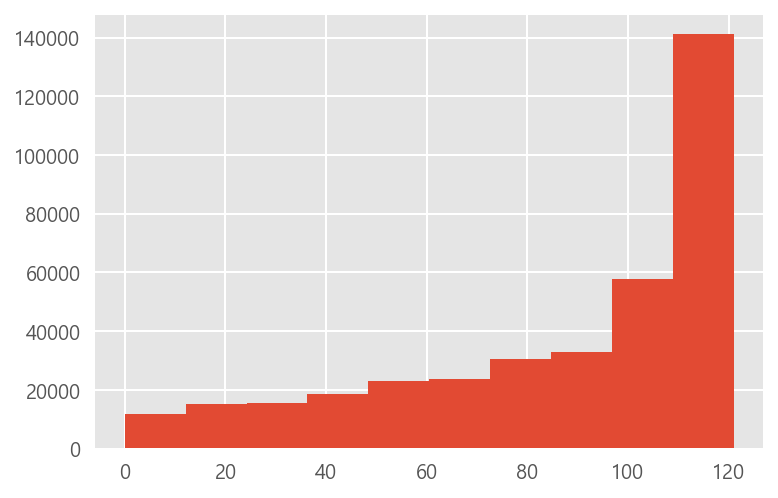

In [148]:
plt.hist(rfm['Recency'])

(array([ 81974., 127282.,  60992.,  31833.,  26817.,  12531.,  14479.,
          9041.,   5253.,    234.]),
 array([0.05737705, 0.95163934, 1.84590164, 2.74016393, 3.63442623,
        4.52868852, 5.42295082, 6.31721311, 7.21147541, 8.1057377 ,
        9.        ]),
 <BarContainer object of 10 artists>)

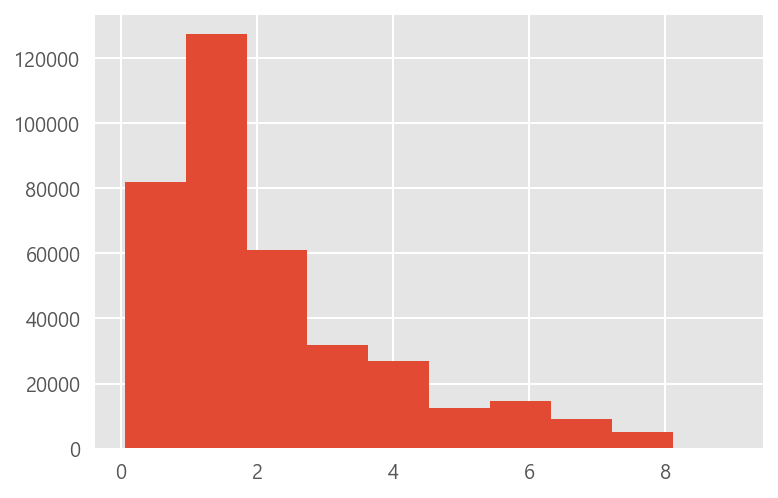

In [149]:
plt.hist(rfm['Frequency'])

(array([  6962.,   2005.,   2889.,   2466.,  22147., 114663., 124892.,
         43685.,  24244.,  26483.]),
 array([  60.,  154.,  248.,  342.,  436.,  530.,  624.,  718.,  812.,
         906., 1000.]),
 <BarContainer object of 10 artists>)

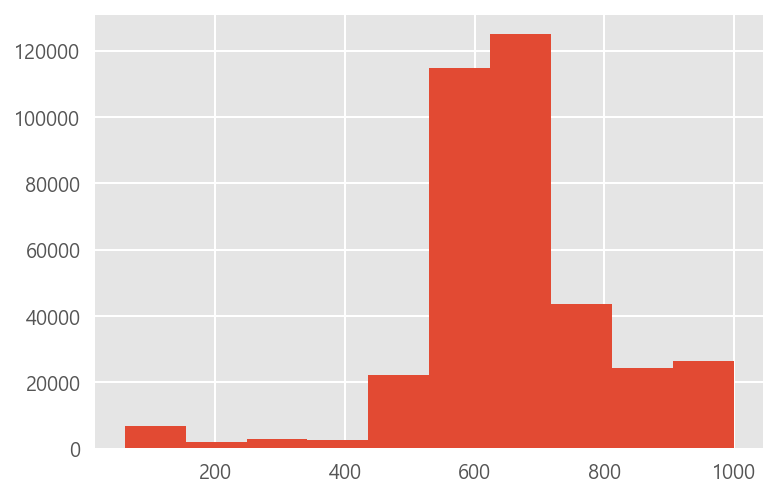

In [150]:
plt.hist(rfm['credit_score'])

In [140]:
# 스케일링한 후 데이터프레임으로 저장
scaler = StandardScaler()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm.iloc[:,1:]))
# 컬럼명을 변경해줌
rfm_scaled.columns = ['Recency', 'Frequency', 'credit_score']
# user_id에 대한 정보를 삽입해줌
rfm_scaled.insert(0, 'user_id', rfm['user_id']);rfm_scaled

,user_id,Recency,Frequency,credit_score
0,1,0.591239,-0.386808,0.651691
1,7,-0.153718,-0.666999,-0.493010
2,9,-0.183517,-0.666999,1.055703
3,11,0.501844,-0.106616,0.062507
4,12,1.008415,-0.907163,-1.151934
...,...,...,...,...
370431,879692,-0.958272,-0.106616,0.921032
370432,879693,0.978617,-0.737047,0.099541
370433,879694,-1.703229,1.014151,-0.098475
370434,879695,-0.004727,1.014151,-0.098475


- kmeans

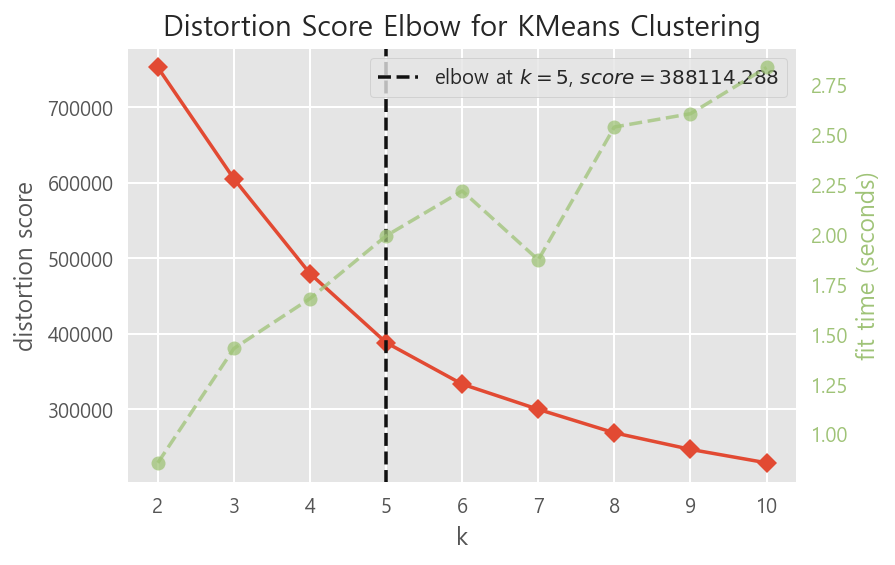

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [141]:
kmeans = KMeans(random_state=np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k=(2,11))
elb_visualizer.fit(rfm_scaled.iloc[:,1:])
elb_visualizer.show()

- 시각화

In [142]:
# 최종 모델로 군집화 후 결과 추출
model_5clust = KMeans(n_clusters = 5, random_state=np.random.RandomState(seed=42))
cluster = model_5clust.fit_predict(rfm_scaled.iloc[:,1:])

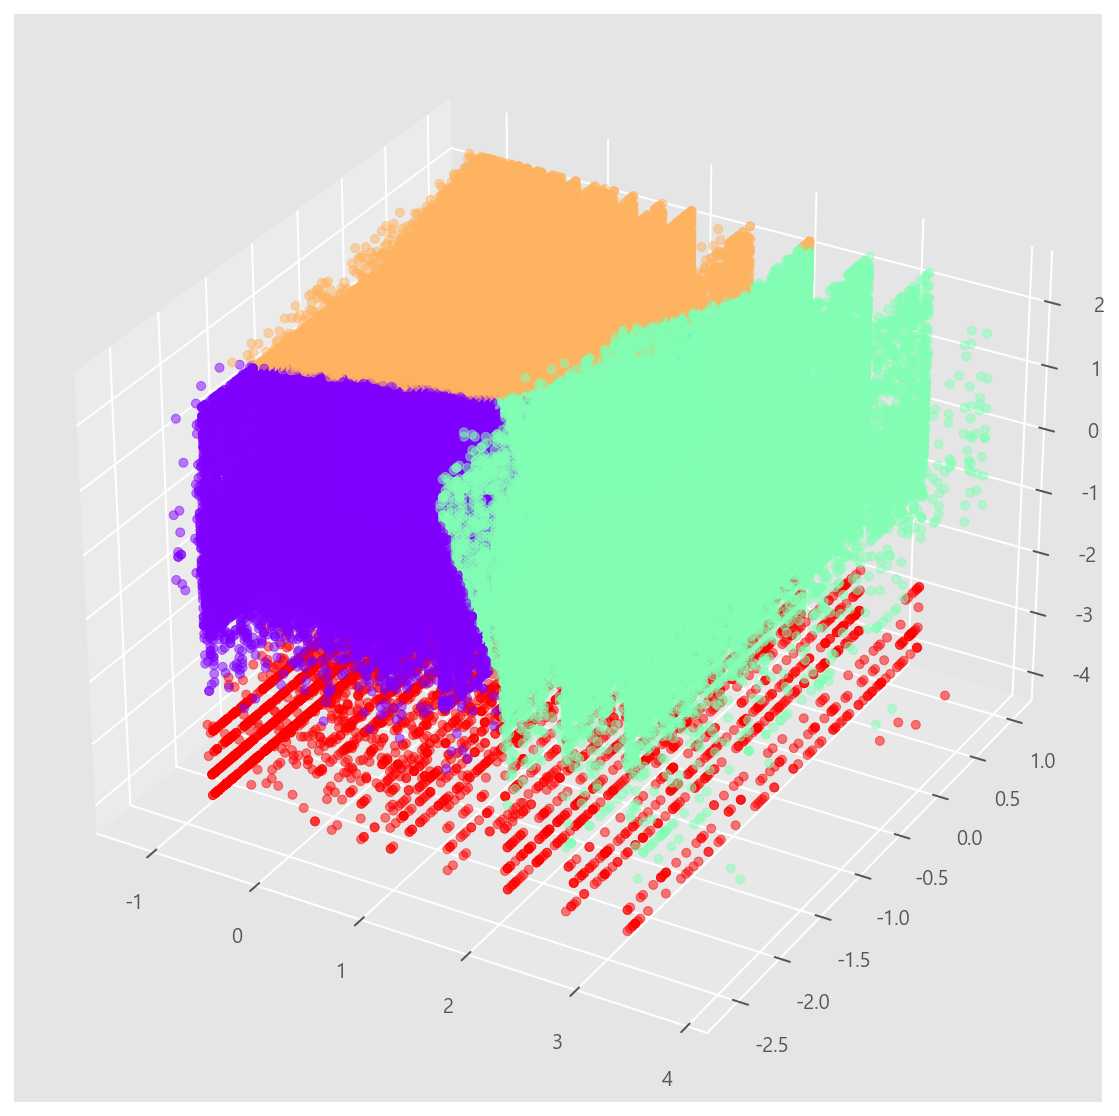

In [143]:
# 3차원 시각화로 군집 확인
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = rfm_scaled['Frequency']
y = rfm_scaled['Recency']
z = rfm_scaled['credit_score']
ax.scatter(x, y, z, c = cluster, s= 20, alpha=0.5, cmap='rainbow')
plt.show()

- 실루엣 계수

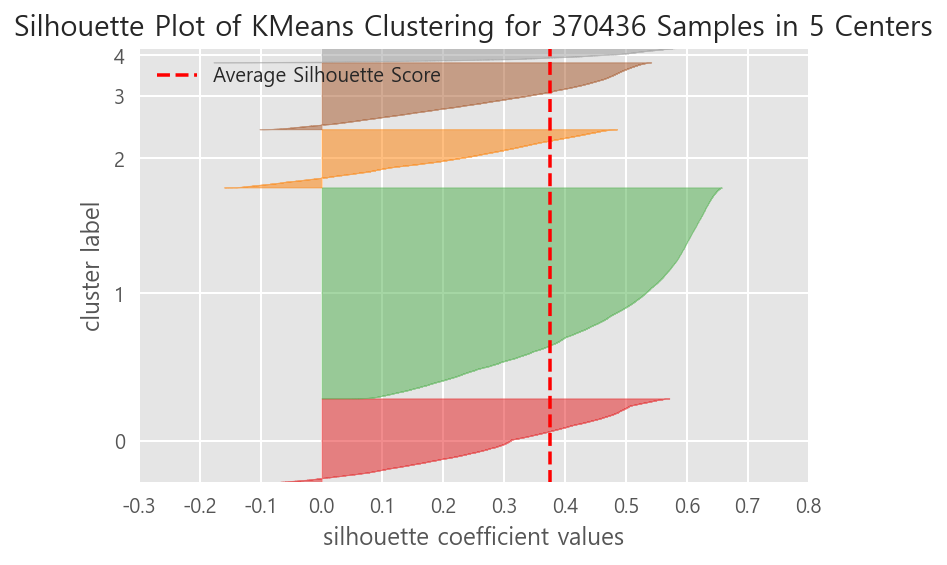

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 370436 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [145]:
# 오래걸림
model_5clust = KMeans(n_clusters = 5, random_state=np.random.RandomState(seed=42))

sil_visualizer = SilhouetteVisualizer(model_5clust)
sil_visualizer.fit(rfm_scaled.iloc[:,1:])
sil_visualizer.show()

In [146]:
import time
print(time.time())

1665602293.5362287


    - cluster에 따른 사용자 수 확인

In [144]:
pd.DataFrame(cluster).value_counts()

1    179739
0     71708
3     56967
2     49589
4     12433
dtype: int64

## User Clustering

- 고객을 적절하게 나눠줄 수 있는 피처를 찾아보자

In [125]:
# 군집화 해야하는 총고객은 370436명
user['user_id'].nunique()

370436

In [143]:
# 고객에 대한 데이터를 생성함
user_df = user.groupby('user_id').mean()[['age', 'credit_score', 'income_rating']].reset_index()

- scaling

In [145]:
# 스케일링한 후 데이터프레임으로 저장
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(user_df.iloc[:,1:]))
# 컬럼명을 변경해줌
scaled_df.columns = ['age', 'credit_score', 'income_rating']
# user_id에 대한 정보를 삽입해줌
scaled_df.insert(0, 'user_id', user_df['user_id']);scaled_df

,user_id,age,credit_score
0,1,-1.589380,0.651691
1,7,-0.212144,-0.493010
2,9,-1.222117,1.055703
3,11,-1.313933,0.062507
4,12,-0.763039,-1.151934
...,...,...,...
370431,879692,-0.854854,0.921032
370432,879693,-1.681196,0.099541
370433,879694,-0.763039,-0.098475
370434,879695,-1.222117,-0.098475


- Clustering

    - kmeans

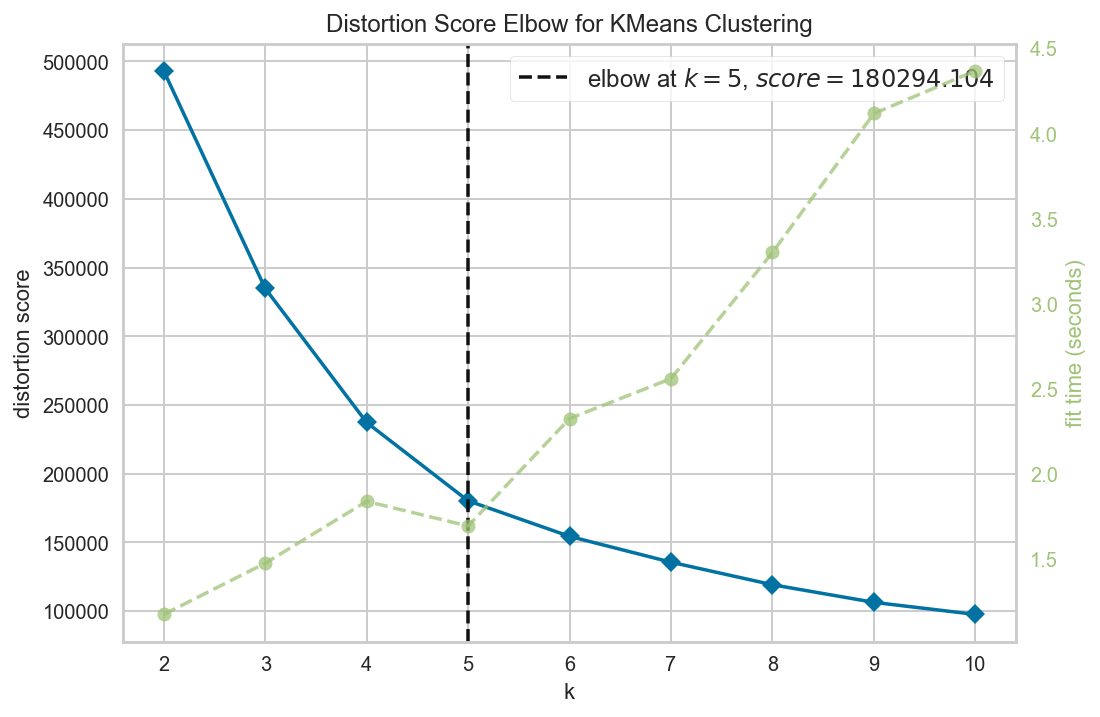

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [146]:
kmeans = KMeans(random_state=np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k=(2,11))
elb_visualizer.fit(scaled_df.iloc[:,1:])
elb_visualizer.show()

- 실루엣 계수 확인

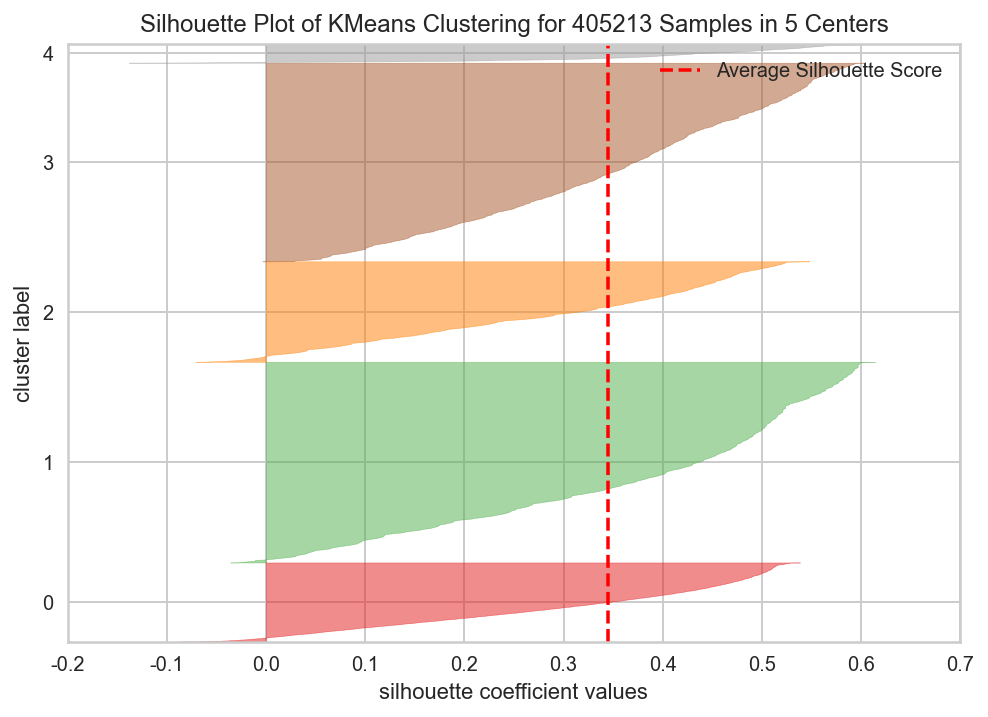

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 405213 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [54]:
# 오래걸림
model_5clust = KMeans(n_clusters = 5, random_state=np.random.RandomState(seed=42))

sil_visualizer = SilhouetteVisualizer(model_5clust)
sil_visualizer.fit(scaled_df.iloc[:,1:])
sil_visualizer.show()

- 시각화

In [134]:
# 최종 모델로 군집화 후 결과 추출
model_5clust = KMeans(n_clusters = 5, random_state=np.random.RandomState(seed=42))
cluster = model_5clust.fit_predict(scaled_df.iloc[:,1:])

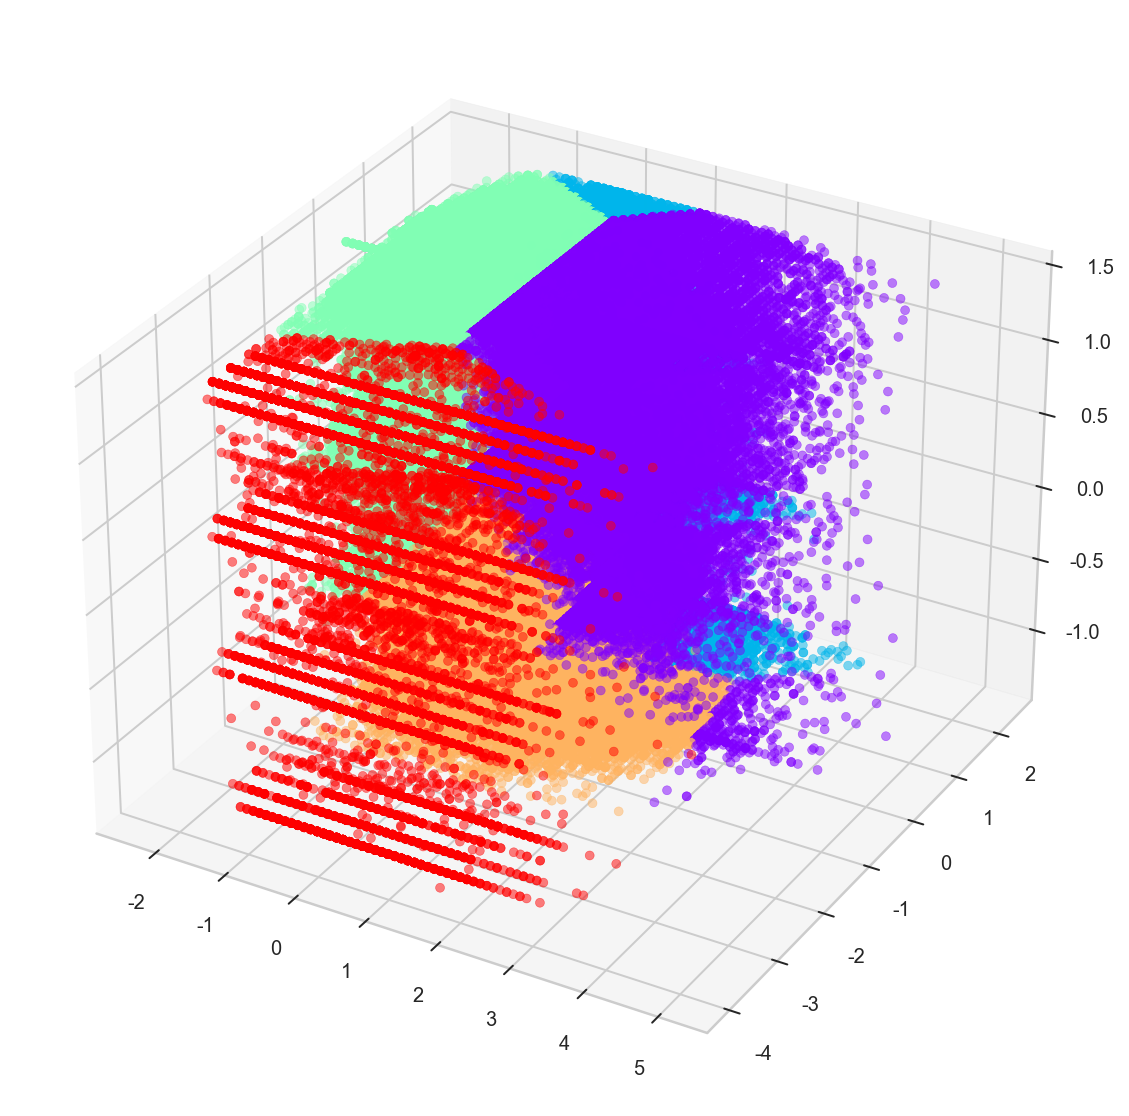

In [135]:
# 3차원 시각화로 군집 확인
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = scaled_df['age']
y = scaled_df['credit_score']
z = scaled_df['income_rating']
ax.scatter(x, y, z, c = cluster, s= 20, alpha=0.5, cmap='rainbow')
plt.show()

## END